# Data Preparation - Santarem (New)

This notebook extracts terrain proportions from neighborhood maps and decomposes
neighborhood-level OVT and ADT data into terrain-specific values.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from PIL import Image
from scipy import optimize
from scipy.stats import pearsonr
import readHistData as hist

## 1. Load Observed Data from CSV

In [2]:
df = pd.read_csv('../data/Santarem.csv')
print(f"Loaded {len(df)} rows of data")
df.head()

Loaded 24 rows of data


,ADT_Jd_Santarem,ADT_Republica,ADT_Santarenzinho,OVT_Jd_Santarem,OVT_Republica,OVT_Santarenzinho,month,mean_prec,mean_t_min,mean_t_med,mean_t_max
0,0.129870,0.080169,0.126582,78.696970,56.403361,121.423729,2010_03,62.950,23.858571,26.208571,28.750714
1,0.000000,0.042553,0.110169,34.878261,45.034188,48.373913,2010_04,109.000,23.914881,26.065476,28.462500
2,0.050000,0.029289,0.079498,55.514286,36.864407,43.083333,2010_05,112.300,23.992679,25.746607,27.963155
3,0.008333,0.021008,0.045833,33.837607,26.966387,33.546218,2010_06,54.350,23.724405,25.721429,27.824405
4,0.025000,0.079167,0.050000,50.439655,48.651786,36.296610,2010_07,26.025,23.260714,25.860714,28.328571


In [3]:
days = [i * 30 for i in range(len(df))]

JdSantaremOVT = df['OVT_Jd_Santarem'].ffill().bfill().values
RepublicaOVT = df['OVT_Republica'].ffill().bfill().values
SantarenzinhoOVT = df['OVT_Santarenzinho'].ffill().bfill().values

JdSantaremADT = df['ADT_Jd_Santarem'].ffill().bfill().values
RepublicaADT = df['ADT_Republica'].ffill().bfill().values
SantarenzinhoADT = df['ADT_Santarenzinho'].ffill().bfill().values

print(f"Days: {days[:5]}... to {days[-5:]}")
print(f"Number of time points: {len(days)}")

Days: [0, 30, 60, 90, 120]... to [570, 600, 630, 660, 690]
Number of time points: 24


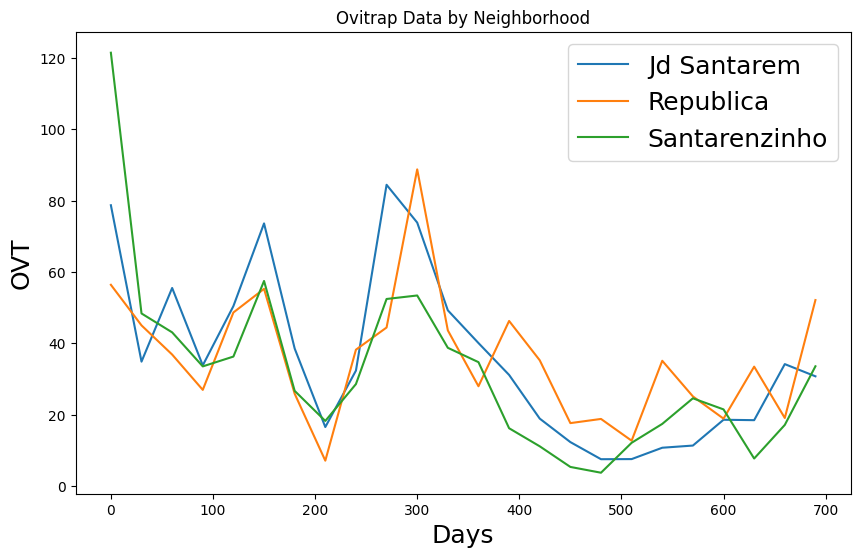

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(days, JdSantaremOVT, label='Jd Santarem')
plt.plot(days, RepublicaOVT, label='Republica')
plt.plot(days, SantarenzinhoOVT, label='Santarenzinho')
plt.legend(fontsize=18)
plt.xlabel("Days", fontsize=18)
plt.ylabel("OVT", fontsize=18)
plt.title("Ovitrap Data by Neighborhood")
plt.show()

## 2. Extract Terrain Proportions from Maps

In [5]:
def isGreen(rgb):
    r, g, b = rgb
    if g > r and g > b and g > 50:
        return True
    if g > 40 and g > r * 0.9 and g > b * 1.1:
        return True
    return False

def isStreet(rgb_map):
    r, g, b = rgb_map
    if b > r and 200 < b < 245 and 200 < g < 235:
        if abs(r - g) < 30:
            return True
    return False

def isWater(rgb_map):
    r, g, b = rgb_map
    if b > 200 and b > r + 50 and b > g + 30:
        return True
    return False

def count_terrain_from_images(roadmap_path, satellite_path):
    roadmap = Image.open(roadmap_path).convert('RGB')
    satellite = Image.open(satellite_path).convert('RGB')
    width, height = roadmap.size
    if satellite.size != (width, height):
        satellite = satellite.resize((width, height))
    water, parks, streets, houses = 0, 0, 0, 0
    step = 3
    for x in range(0, width, step):
        for y in range(0, height, step):
            pixel_map = roadmap.getpixel((x, y))[:3]
            pixel_sat = satellite.getpixel((x, y))[:3]
            if isWater(pixel_map):
                water += 1
            elif isStreet(pixel_map):
                streets += 1
            elif isGreen(pixel_sat):
                parks += 1
            else:
                houses += 1
    return [water, parks, streets, houses]

In [6]:
# Note: Order must match CSV columns order for proper matrix multiplication
neighborhoods = ['Jd_Santarem', 'Republica', 'Santarenzinho']
neighborhoods_display = ['Jd Santarem', 'Republica', 'Santarenzinho']
map_base_path = '../maps/Santarem_PA'

proportions_raw = []
for neighborhood in neighborhoods:
    roadmap_path = f"{map_base_path}/{neighborhood}/roadmap.png"
    satellite_path = f"{map_base_path}/{neighborhood}/satellite.png"
    print(f"Processing {neighborhood}...")
    counts = count_terrain_from_images(roadmap_path, satellite_path)
    print(f"  Raw counts [water, parks, streets, houses]: {counts}")
    proportions_raw.append(counts)

Processing Jd_Santarem...
  Raw counts [water, parks, streets, houses]: [0, 8965, 29556, 143808]
Processing Republica...
  Raw counts [water, parks, streets, houses]: [0, 16593, 28935, 136801]
Processing Santarenzinho...
  Raw counts [water, parks, streets, houses]: [0, 13409, 26506, 142414]


In [7]:
proportions = [np.array(c) / sum(c) for c in proportions_raw]
matProporcoes = np.matrix(proportions)

print("Proportions [water, parks, streets, houses]:")
for name, props in zip(neighborhoods_display, proportions):
    print(f"  {name}: water={props[0]:.4f}, parks={props[1]:.4f}, streets={props[2]:.4f}, houses={props[3]:.4f}")
print("\nProportions Matrix:")
print(matProporcoes)

Proportions [water, parks, streets, houses]:
  Jd Santarem: water=0.0000, parks=0.0492, streets=0.1621, houses=0.7887
  Republica: water=0.0000, parks=0.0910, streets=0.1587, houses=0.7503
  Santarenzinho: water=0.0000, parks=0.0735, streets=0.1454, houses=0.7811

Proportions Matrix:
[[0.         0.04916936 0.16210257 0.78872807]
 [0.         0.09100582 0.15869664 0.75029754]
 [0.         0.07354288 0.14537457 0.78108255]]


## 3. Decompose OVT Data

In [8]:
O_agua, O_parque, O_rua, O_casa = [], [], [], []
OVT_data = [JdSantaremOVT, RepublicaOVT, SantarenzinhoOVT]

for t in range(len(days)):
    vetOvo = [OVT_data[i][t] for i in range(3)]
    def f(x):
        return np.linalg.norm(matProporcoes @ x - vetOvo)
    result = optimize.minimize(f, [0, 0, 0, 0], bounds=[(0, None)]*4)
    O_agua.append(result.x[0])
    O_parque.append(result.x[1])
    O_rua.append(result.x[2])
    O_casa.append(result.x[3])

O_agua, O_parque, O_rua, O_casa = np.array(O_agua), np.array(O_parque), np.array(O_rua), np.array(O_casa)
print("OVT decomposition complete.")

OVT decomposition complete.


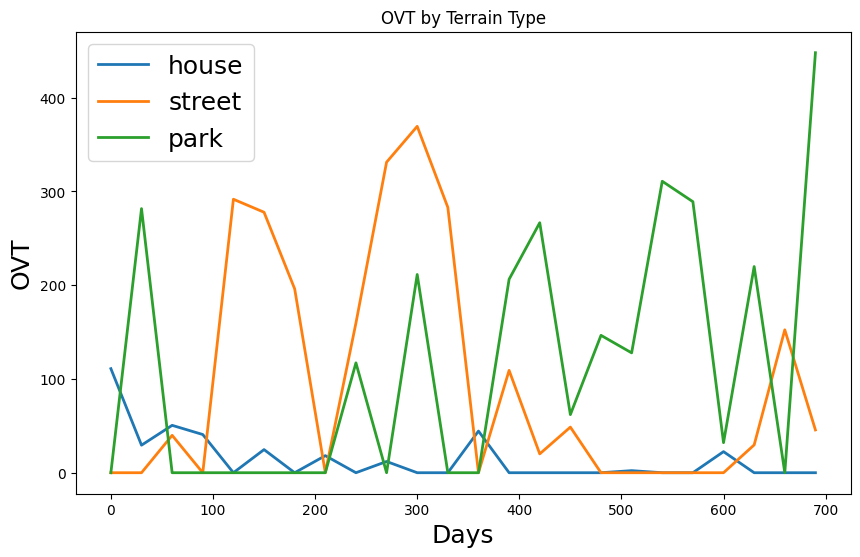

In [9]:
plt.figure(figsize=(10, 6))
plt.plot(days, O_casa, label="house", linewidth=2)
plt.plot(days, O_rua, label="street", linewidth=2)
plt.plot(days, O_parque, label="park", linewidth=2)
plt.legend(fontsize=18)
plt.xlabel("Days", fontsize=18)
plt.ylabel("OVT", fontsize=18)
plt.title("OVT by Terrain Type")
plt.show()

## 4. Decompose ADT Data

In [10]:
ADT_agua, ADT_parque, ADT_rua, ADT_casa = [], [], [], []
ADT_data = [JdSantaremADT, RepublicaADT, SantarenzinhoADT]

for t in range(len(days)):
    vetAdt = [ADT_data[i][t] for i in range(3)]
    def f(x):
        return np.linalg.norm(matProporcoes @ x - vetAdt)
    result = optimize.minimize(f, [0, 0, 0, 0], bounds=[(0, None)]*4)
    ADT_agua.append(result.x[0])
    ADT_parque.append(result.x[1])
    ADT_rua.append(result.x[2])
    ADT_casa.append(result.x[3])

ADT_agua, ADT_parque, ADT_rua, ADT_casa = np.array(ADT_agua), np.array(ADT_parque), np.array(ADT_rua), np.array(ADT_casa)
print("ADT decomposition complete.")

ADT decomposition complete.


## 5. Validate Reconstruction

In [11]:
reconstructed_OVT = [np.zeros(len(days)) for _ in range(3)]
for t in range(len(days)):
    R = matProporcoes @ [O_agua[t], O_parque[t], O_rua[t], O_casa[t]]
    for i in range(3):
        reconstructed_OVT[i][t] = R[0, i]

print("Reconstruction Correlations (OVT):")
for i, name in enumerate(neighborhoods_display):
    corr = pearsonr(reconstructed_OVT[i], OVT_data[i])[0]
    print(f"  {name}: {corr:.4f}")

Reconstruction Correlations (OVT):
  Jd Santarem: 0.9704
  Republica: 0.8960
  Santarenzinho: 0.9316


## 6. Save Results

In [12]:
data_new = {
    "Day": days,
    "OVT_house": O_casa,
    "OVT_park": O_parque,
    "OVT_street": O_rua,
    "ADT_house": ADT_casa,
    "ADT_park": ADT_parque,
    "ADT_street": ADT_rua,
    "Temperature": [hist.temperature(t) for t in days],
    "Pluviosity": [hist.pluviosity(t) for t in days]
}

df_new = pd.DataFrame(data_new)
df_new.to_csv("dataNew.csv", index=False)
print("Saved dataNew.csv")
df_new.head(10)

Saved dataNew.csv


,Day,OVT_house,OVT_park,OVT_street,ADT_house,ADT_park,ADT_street,Temperature,Pluviosity
0,0,110.984733,0.000000,0.000000,0.145646,0.000000,0.000000,26.208571428575,62.95
1,30,29.383157,281.667689,0.000000,0.022875,0.531267,0.000000,26.065476190475003,109.0
2,60,50.537376,0.000000,39.879685,0.068801,0.000000,0.000000,25.74660714285,112.3
3,90,40.734610,0.000000,0.000000,0.000014,0.353233,0.000000,25.721428571425,54.349999999999994
4,120,0.000000,0.000000,291.668835,0.000000,0.751851,0.000000,25.860714285725003,26.025
5,150,24.661964,0.000000,277.808523,0.000000,0.000000,0.182026,26.28714285715,37.1
6,180,0.000000,0.000000,196.092415,0.014110,0.044829,0.000000,28.4619047619,1.9500000000000028
7,210,18.202375,0.000000,0.000000,0.000000,0.267205,0.000000,29.500595238125,1.425
8,240,0.000000,117.165065,159.668853,0.000000,0.488869,0.000000,29.2773809524,26.65
9,270,11.974182,0.000000,331.197286,0.000000,0.060635,0.171549,28.155952380975,43.0
